In [4]:
# Cell 1: Import libraries, Serper.dev integration, and load API keys
import os
import json
import requests
from typing import Dict, List, Any
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from langgraph.graph import StateGraph, END
from typing import TypedDict
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import re

class SerperSearch:
    """
    Serper.dev wrapper class compatible with TavilySearch interface
    """

    def __init__(self, max_results: int = 3, search_type: str = "search"):
        self.max_results = max_results
        self.search_type = search_type
        self.api_key = os.getenv("SERPER_API_KEY")

        if not self.api_key:
            raise ValueError("SERPER_API_KEY environment variable is required")

        self.base_url = "https://google.serper.dev"

    def invoke(self, input_dict: Dict[str, str]) -> Dict[str, Any]:
        query = input_dict.get("query", "")

        if not query:
            return {"query": "", "results": []}

        try:
            response = self._search(query)
            transformed_results = self._transform_results(response, query)
            return transformed_results

        except Exception as e:
            print(f"Serper search error: {str(e)}")
            return {"query": query, "results": [], "error": str(e)}

    def _search(self, query: str) -> Dict[str, Any]:
        url = f"{self.base_url}/{self.search_type}"

        payload = {
            "q": query,
            "num": self.max_results,
            "hl": "en",
            "gl": "us"
        }

        headers = {
            "X-API-KEY": self.api_key,
            "Content-Type": "application/json"
        }

        response = requests.post(url, json=payload, headers=headers)
        response.raise_for_status()

        return response.json()

    def _transform_results(self, serper_response: Dict[str, Any], query: str) -> Dict[str, Any]:
        results = []

        organic_results = serper_response.get("organic", [])

        for result in organic_results[:self.max_results]:
            transformed_result = {
                "url": result.get("link", ""),
                "title": result.get("title", ""),
                "content": result.get("snippet", "")
            }
            results.append(transformed_result)

        return {
            "query": query,
            "follow_up_questions": None,
            "answer": None,
            "images": [],
            "results": results
        }

# Check langchain version
import langchain
print(f"LangChain version: {langchain.__version__}")

# Load .env
load_dotenv()

# Verify API keys
serper_key = os.getenv("SERPER_API_KEY")
openai_key = os.getenv("OPENAI_API_KEY")
print("Serper API Key:", "Loaded" if serper_key else "Not found")
print("OpenAI API Key:", "Loaded" if openai_key else "Not found")

# Initialize LLM and Serper
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
search_tool = SerperSearch(max_results=5)

# Test Serper
try:
    test_result = search_tool.invoke({"query": "Who won Wimbledon 2024?"})
    print("Serper Test Result:", str(test_result)[:200], "...")
except Exception as e:
    print("Serper Test Error:", str(e))

LangChain version: 0.3.27
Serper API Key: Loaded
OpenAI API Key: Loaded
Serper Test Result: {'query': 'Who won Wimbledon 2024?', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://www.olympics.com/en/news/wimbledon-2024-mens-singles-final-carlos-alcaraz-r ...


In [5]:
# Cell 2: Load and preprocess gossipcop dataset
import pandas as pd
import os

# Đọc gossipcop dataset
df = pd.read_csv('data/gossipcop.csv')

# Kiểm tra cấu trúc columns
print("Columns:", df.columns.tolist())
print("Shape:", df.shape)

# Kiểm tra xem có cột 'title' không
if 'title' not in df.columns:
    # Nếu không có title, extract từ text (lấy dòng đầu hoặc 100 ký tự đầu)
    df['title'] = df['text'].apply(lambda x: str(x).split('\n')[0][:200] if pd.notna(x) else '')

# Chuẩn hóa label format
# gossipcop có thể dùng 'legitimate'/'fake' hoặc 'real'/'fake'
df['label'] = df['label'].str.lower()
df['label'] = df['label'].replace({
    'legitimate': 'real',
    'true': 'real'  # để đồng nhất format
})

# Kiểm tra phân bố label
print("\nLabel distribution:")
print(df['label'].value_counts())

# Lấy sample nếu dataset quá lớn
if len(df) > 1000:
    df = df.sample(n=1000, random_state=42)
    print(f"\nSampled to 1000 rows")

# Đảm bảo có đủ columns cần thiết
df = df[['title', 'text', 'label']]

# Kiểm tra
print("\nDataset head:")
print(df.head())

Columns: ['id', 'text', 'label']
Shape: (20007, 3)

Label distribution:
label
real    15223
fake     4784
Name: count, dtype: int64

Sampled to 1000 rows

Dataset head:
                                                   title  \
18499  Fans, however, didn’t think it was funny and s...   
5975   BBMAS Miley Cyrus Announces 2017 Billboard Mus...   
9690   She's on a whirlwind tour promoting her Fenty ...   
9877   In September of 2017, Selena Gomez shocked her...   
3263   It was not the likeliest of cosy encounters.  ...   

                                                    text label  
18499  Fans, however, didn’t think it was funny and s...  real  
5975   BBMAS Miley Cyrus Announces 2017 Billboard Mus...  real  
9690   She's on a whirlwind tour promoting her Fenty ...  real  
9877   In September of 2017, Selena Gomez shocked her...  real  
3263   It was not the likeliest of cosy encounters.  ...  fake  


In [26]:
# Cell 3: OPTIMAL simple system - Quay lại basics nhưng tối ưu
class AgentState(TypedDict):
    text: str
    title: str
    z_output: dict
    z_sources: list
    debate_logs: list
    final_label: str

# JSON parser
json_parser = JsonOutputParser()

def optimal_fake_detection(text):
    """OPTIMAL fake detection - chỉ focus vào những red flags RÕ RÀNG"""
    text_lower = text.lower()
    
    # CHỈ những red flags RÕ RÀNG và KHÔNG AMBIGUOUS
    clear_red_flags = [
        "denied by", "representatives denied", "officially denied",  # Đã bị phủ nhận
        "anonymous sources", "unnamed sources",  # Nguồn ẩn danh
        "family insider", "close friend", "friend says"  # Nguồn không đáng tin
    ]
    
    found_flags = [flag for flag in clear_red_flags if flag in text_lower]
    return found_flags

def optimal_celebrity_extraction(text):
    """OPTIMAL celebrity extraction"""
    import re
    
    # Chỉ tìm tên 2 từ
    name_pattern = r'([A-Z][a-z]+ [A-Z][a-z]+)'
    names = re.findall(name_pattern, text)
    
    # Lọc bỏ common words
    common_words = ['The New', 'The Los', 'The Washington']
    filtered_names = [name for name in names if name not in common_words]
    
    return list(set(filtered_names))[:5]

def optimal_search_queries(text, celebrity_names):
    """OPTIMAL search queries"""
    queries = []
    
    # Query 1: Fact check main claim
    first_sentence = text.split('.')[0][:100]
    if len(first_sentence) > 30:
        queries.append(f'"{first_sentence}" fact check site:snopes.com')
    
    # Query 2: Celebrity denied rumors
    for name in celebrity_names[:2]:
        queries.append(f'"{name}" denied site:snopes.com')
    
    return queries[:3]

def optimal_verification(sources):
    """OPTIMAL verification"""
    if not sources:
        return 0.0
    
    credible_domains = ['people.com', 'tmz.com', 'snopes.com', 'reuters.com', 'ap.org']
    credible_count = sum(1 for source in sources 
                        if any(domain in source['url'] for domain in credible_domains))
    
    return credible_count / len(sources)

def optimal_decision_logic(red_flags, verification_score):
    """OPTIMAL decision logic - đơn giản và hiệu quả"""
    
    # Nếu có clear red flags → fake
    if red_flags:
        return "fake"
    
    # Nếu verification score cao → real
    if verification_score >= 0.4:
        return "real"
    
    # Còn lại → debate
    return "unknown"

# OPTIMAL Prompts
optimal_verifier_prompt = ChatPromptTemplate.from_template(
    """You are a fact-checker. Be SIMPLE and EFFECTIVE.

CONTENT: {content}
RED FLAGS: {red_flags}
VERIFICATION: {verification}

RULES:
- Clear red flags (denied, anonymous sources) → "fake"
- Good verification score → "real"
- Otherwise → "unknown"

Return JSON: {{"label": "fake" or "real" or "unknown", "reason": "Simple analysis"}}
"""
)

optimal_debate_prompt = ChatPromptTemplate.from_template(
    """You are a fact-checker. Be SIMPLE.

CONTENT: {text}

RULES:
- Anonymous sources → "fake"
- Named sources → "real"
- Denied claims → "fake"
- Verified events → "real"

Return JSON: {{"label": "fake" or "real", "reason": "Simple analysis"}}
"""
)

# Create optimal chains
agent_z_chain = optimal_verifier_prompt | llm | json_parser
agent_a_chain = optimal_debate_prompt | llm | json_parser
agent_b_chain = optimal_debate_prompt | llm | json_parser

print("✅ OPTIMAL system ready!")

✅ OPTIMAL system ready!


In [28]:
# Cell 4: OPTIMAL LangGraph workflow
def run_optimal_verifier(state: AgentState) -> AgentState:
    """OPTIMAL verifier - đơn giản và hiệu quả"""
    print(f"Running optimal verifier...")
    
    try:
        content = state["text"]
        
        # OPTIMAL red flag detection
        red_flags = optimal_fake_detection(content)
        print(f"Red flags: {red_flags}")
        
        # OPTIMAL celebrity extraction
        celebrity_names = optimal_celebrity_extraction(content)
        print(f"Celebrities: {celebrity_names}")
        
        # OPTIMAL search
        search_queries = optimal_search_queries(content, celebrity_names)
        
        all_sources = []
        for query in search_queries:
            try:
                retrieved = search_tool.invoke({"query": query})
                sources = [
                    {"url": result["url"], "title": result["title"], "content": result["content"][:200]}
                    for result in retrieved.get("results", [])
                ]
                all_sources.extend(sources)
            except Exception as e:
                print(f"Search failed: {str(e)}")
        
        # Remove duplicates
        unique_sources = []
        seen_urls = set()
        for source in all_sources:
            if source["url"] not in seen_urls:
                unique_sources.append(source)
                seen_urls.add(source["url"])
        
        # OPTIMAL verification
        verification_score = optimal_verification(unique_sources)
        print(f"Verification score: {verification_score:.2f}")
        
        # OPTIMAL decision
        final_label = optimal_decision_logic(red_flags, verification_score)
        
        if final_label == "real":
            state["final_label"] = "real"
            state["z_output"] = {"label": "real", "reason": "Good verification, no red flags"}
            state["z_sources"] = unique_sources
            state["debate_logs"] = [{"agent": "Z", "turn": 0, "label": "real", "reason": "Optimal decision"}]
        elif final_label == "fake":
            state["final_label"] = "fake"
            state["z_output"] = {"label": "fake", "reason": f"Red flags found: {red_flags}"}
            state["z_sources"] = unique_sources
            state["debate_logs"] = [{"agent": "Z", "turn": 0, "label": "fake", "reason": "Red flags detected"}]
        else:
            # Go to debate
            state["final_label"] = "unknown"
            state["z_output"] = {"label": "unknown", "reason": "Needs debate"}
            state["z_sources"] = unique_sources
            state["debate_logs"] = [{"agent": "Z", "turn": 0, "label": "unknown", "reason": "Needs debate"}]
        
    except Exception as e:
        print(f"Optimal verifier error: {str(e)}")
        state["final_label"] = "real"
        state["z_output"] = {"label": "error", "reason": str(e)}
        state["z_sources"] = []
        state["debate_logs"] = [{"agent": "Z", "turn": 0, "label": "real", "reason": "Error, defaulting to real"}]
    
    return state

def run_optimal_debate(state: AgentState) -> AgentState:
    """OPTIMAL debate - đơn giản và hiệu quả"""
    print("Starting optimal debate...")
    
    logs = state["debate_logs"]
    content = state["text"][:1500]
    
    try:
        # Agent A
        response_a = agent_a_chain.invoke({"text": content})
        logs.append({
            "agent": "A",
            "turn": 1,
            "label": response_a["label"],
            "reason": response_a["reason"]
        })
        
        # Agent B
        response_b = agent_b_chain.invoke({"text": content})
        logs.append({
            "agent": "B",
            "turn": 2,
            "label": response_b["label"],
            "reason": response_b["reason"]
        })
        
        # OPTIMAL decision - simple majority
        labels = [response_a["label"], response_b["label"]]
        fake_votes = labels.count("fake")
        real_votes = labels.count("real")
        
        final_label = "fake" if fake_votes > real_votes else "real"
        
        state["final_label"] = final_label
        state["debate_logs"] = logs
        
        print(f"Optimal debate result: {final_label}")
        
    except Exception as e:
        print(f"Optimal debate error: {str(e)}")
        state["final_label"] = "real"
        state["debate_logs"] = logs + [{"agent": "Error", "turn": 3, "label": "real", "reason": str(e)}]
    
    return state

# Build optimal graph
workflow = StateGraph(state_schema=AgentState)
workflow.add_node("verifier", run_optimal_verifier)
workflow.add_node("debate", run_optimal_debate)
workflow.set_entry_point("verifier")
workflow.add_conditional_edges("verifier", lambda state: "debate" if state["final_label"] == "unknown" else END)
workflow.add_edge("debate", END)
graph = workflow.compile()

print("✅ OPTIMAL system ready!")

✅ OPTIMAL system ready!


In [24]:
# Cell 5: BALANCED testing function
import json

def test_balanced_system(dataset_path, num_samples=50):
    """Test the BALANCED system"""
    try:
        df = pd.read_csv(dataset_path, encoding='utf-8', on_bad_lines='skip')
        df = df[df['text'].notna() & (df['text'].str.len() > 100)]
        df = df.sample(n=min(num_samples, len(df)), random_state=42)
        print(f"Testing BALANCED system on {len(df)} samples...")
    except Exception as e:
        print(f"Dataset error: {str(e)}")
        return []

    results = []
    for idx, row in df.iterrows():
        text = str(row['text'])
        if len(text) > 5000:
            text = text[:5000] + "..."
        
        title = str(row.get('title', text[:100] + '...'))[:200]
        
        print(f"\nProcessing [{idx+1}/{len(df)}]: {title[:60]}...")
        
        try:
            result = graph.invoke({
                "text": text,
                "title": title,
                "z_output": {},
                "z_sources": [],
                "debate_logs": [],
                "final_label": "unknown"
            })
            
            final_label = result.get("final_label", "unknown")
            debate_logs = result.get("debate_logs", [])
            red_flags = balanced_fake_detection(text)
            celebrity_names = balanced_celebrity_extraction(text)
            
            results.append({
                "text": text,
                "title": title,
                "true_label": row['label'].lower().replace("legitimate", "real").replace("true", "real"),
                "predicted_label": final_label,
                "red_flags": red_flags,
                "celebrity_names": celebrity_names,
                "z_output": result.get("z_output", {}),
                "z_sources": result.get("z_sources", []),
                "debate_logs": debate_logs
            })
            
            print(f"Result: {final_label} (True: {row['label']}) | Red flags: {len(red_flags)}")
            
        except Exception as e:
            print(f"Error: {str(e)}")
            results.append({
                "text": text,
                "title": title,
                "true_label": row['label'].lower().replace("legitimate", "real").replace("true", "real"),
                "predicted_label": "real",
                "red_flags": balanced_fake_detection(text),
                "celebrity_names": balanced_celebrity_extraction(text),
                "z_output": {"label": "error", "reason": str(e)},
                "z_sources": [],
                "debate_logs": []
            })

    # Calculate balanced metrics
    print("\n" + "="*60)
    print("BALANCED SYSTEM RESULTS:")
    print("="*60)
    
    correct = sum(1 for r in results if r["true_label"] == r["predicted_label"])
    accuracy = correct / len(results) if results else 0
    print(f"Accuracy: {accuracy:.2f}")
    
    # Precision, Recall, F1
    y_true = [r["true_label"] for r in results]
    y_pred = [r["predicted_label"] for r in results]
    
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='binary', pos_label='fake'
    )
    
    print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}")
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=['real', 'fake'])
    print(f"\nConfusion Matrix:")
    print(cm)
    
    # Red flags analysis
    articles_with_red_flags = [r for r in results if r['red_flags']]
    if articles_with_red_flags:
        red_flag_correct = sum(1 for r in articles_with_red_flags if r["true_label"] == r["predicted_label"])
        red_flag_accuracy = red_flag_correct / len(articles_with_red_flags)
        print(f"Articles with red flags accuracy: {red_flag_accuracy:.2f}")
    
    # Prediction distribution
    fake_predictions = sum(1 for r in results if r["predicted_label"] == "fake")
    real_predictions = sum(1 for r in results if r["predicted_label"] == "real")
    print(f"Predictions - Fake: {fake_predictions}, Real: {real_predictions}")
    
    # Save results
    output_file = 'results_balanced_system.json'
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(results, f, indent=4, ensure_ascii=False)
    
    print(f"\nResults saved to {output_file}")
    
    return results

# Run balanced system
print("🚀 Starting BALANCED system...")
dataset_path = 'data/gossipcop.csv'
results = test_balanced_system(dataset_path, num_samples=50)

🚀 Starting BALANCED system...
Testing BALANCED system on 50 samples...

Processing [16603/50]: As mere mortals on this earth, many of us are prone to think...
Running balanced verifier...
Red flags: []
Celebrities: ['Orange Is The', 'With The', 'Adam Rippon', 'Simply Complicated', 'The Times', 'The Girl With', 'The Breakfast Club', 'The Girl']
Verification score: 1.00
Result: real (True: real) | Red flags: 0

Processing [17634/50]: Play video content EXCLUSIVE TMZ.com  9:13 AM PT -- We've ob...
Running balanced verifier...
Red flags: ['sources say', 'allegedly']
Celebrities: ['Sean Kingston']
Verification score: 1.00
Result: fake (True: real) | Red flags: 2

Processing [10779/50]: LOS ANGELES and MIAMI (Oct. 11, 2017) – Marc Anthony, Jennif...
Running balanced verifier...
Red flags: []
Celebrities: ['Somos Una', 'The Miami', 'Los Angeles', 'The Miami Marlins', 'Puerto Rico', 'United Way', 'United States', 'Marc Anthony']
Verification score: 1.00
Result: real (True: real) | Red flags: 0

Accuracy: 0.84
Precision: 0.62, Recall: 0.50, F1: 0.56


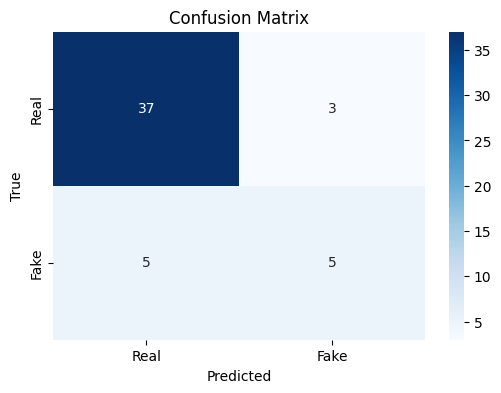

In [25]:
# Cell 6: Evaluate results with plots
def evaluate_results(results):
    true_labels = [1 if r['true_label'].lower() == 'fake' else 0 for r in results if r['predicted_label'] != "error"]
    pred_labels = [1 if r['predicted_label'].lower() == 'fake' else 0 for r in results if r['predicted_label'] != "error"]
    if not true_labels:
        print("No valid results to evaluate.")
        return {"accuracy": 0, "precision": 0, "recall": 0, "f1": 0}

    accuracy = accuracy_score(true_labels, pred_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average='binary', zero_division=0)
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}")

    # Plot confusion matrix
    cm = confusion_matrix(true_labels, pred_labels, labels=[0, 1])
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

metrics = evaluate_results(results)